In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import pickle
import global_variables as gv
import output_functions as of
import matplotlib as mpl
import matplotlib.pyplot as plt

In [73]:
run = 130
range_profile = pickle.load(open(
    'Outputs/Logs/run{}/range_profiles'.format(run), 'rb'))
site_profile = pickle.load(
    open('Outputs/Logs/run{}/site_summary'.format(run), 'rb'))
site_profile['date'] = pd.to_datetime(site_profile['date'])
days_summary = pickle.load(
    open('Outputs/Logs/run{}/days_summary'.format(run),'rb'))
status = pickle.load(
    open('Outputs/Logs/run{}/status'.format(run),'rb'))
journeys_range = pickle.load(
    open('Outputs/journeys_range','rb'))

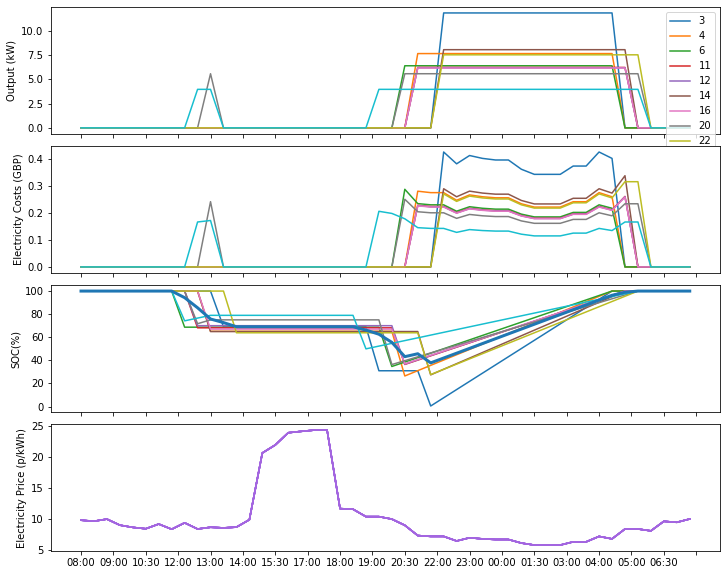

In [74]:
profile = range_profile[range_profile['date']==day]

fig, axs = plt.subplots(
    4,
    figsize=(12,10),
    sharex=True, 
    gridspec_kw={'hspace':0.1})
ca='opt'
x = profile.unstack().index.strftime('%H:%M')
cols = gv.CAT_COLS

axs[0].plot(
    x, 
    profile.unstack()[cols['OUTPUT'][ca]]*2)
axs[0].legend(profile.unstack()[cols['OUTPUT'][ca]].columns)
# axs[0].plot(
#     x,
#     range_profile[cols['OUTPUT'][ca]].groupby('from').sum()*2, linewidth=3)
axs[0].set_ylabel('Output (kW)')

axs[1].plot(
    x, 
    profile.unstack()[cols['ECOST'][ca]]/100)
# axs[1].plot(
#     x,
#     range_profile[cols['ECOST'][ca]].groupby('from').sum()/100, linewidth=3)
axs[1].set_ylabel('Electricity Costs (GBP)')

axs[2].plot(
    x, 
    profile.unstack()[cols['SOC'][ca]])
axs[2].plot(
    x,
    profile[cols['SOC'][ca]].groupby('from').mean(), linewidth=3)
axs[2].set_ylabel('SOC(%)')

axs[3].plot(
    x, 
    profile.unstack()[cols['PRICE']['opt']], 
    color=gv.FPS_PURPLE)
axs[3].set_ylabel('Electricity Price (p/kWh)')
for ax in fig.get_axes():
    ax.xaxis.set_major_locator(plt.MaxNLocator(24))
fig.show()

In [75]:
# Calculates how much charging occurs between arrival and 10pm
days_summary['Charge_late'] = 0
vehicles = profile.index.get_level_values('Vehicle_ID').unique()
for date in days_summary.index:
    profile = range_profile[range_profile['date']==date]
    cutoff = dt.datetime.combine(
        date.to_pydatetime(), dt.time(22,0,0))
    charge = 0
    for veh in vehicles:  
        temp = profile.loc[
            (slice(cutoff), veh), ['Session', 'Output_Opt']]
        last_session = temp['Session'].max()
        charge += temp[temp['Session']==last_session]['Output_Opt'].sum()
    days_summary.loc[date,'Charge_late'] = charge
days_summary['Ratio'] = days_summary['Charge_late'] / days_summary['Output_Opt']
days_summary['Ratio'].describe()

count    210.000000
mean       0.213526
std        0.055087
min        0.000000
25%        0.181145
50%        0.214675
75%        0.247454
max        0.373895
Name: Ratio, dtype: float64